In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv
#!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# train_url = '/content/UNSW_NB15_testing-set.csv'
# test_url = '/content/UNSW_NB15_training-set.csv'

# train_url = 'KDDTrain+.txt'
# test_url = 'KDDTest+.txt'

train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'



In [ ]:
# col_names = ["srcip","sport","dstip","dsport","proto","state","dur","sbytes","dbytes","sttl","dttl","sloss","dloss","service","Sload","Dload","Spkts","Dpkts","swin","dwin","stcpb","dtcpb","smeansz","dmeansz","trans_depth","res_bdy_len","Sjit","Djit","Stime","Ltime","Sintpkt","Dintpkt","tcprtt","synack","ackdat","is_sm_ips_ports","ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd","ct_srv_src","ct_srv_dst","ct_dst_ltm","ct_src_ ltm","ct_src_dport_ltm","ct_dst_sport_ltm","ct_dst_src_ltm","attack_cat","Label"]
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "extra"]

In [ ]:
df = pd.read_csv(train_url,header=None, names = col_names)

df_test = pd.read_csv(test_url, header=None, names = col_names)

In [ ]:
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape) 

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


In [ ]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,extra
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,NaN
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,NaN
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,NaN
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,NaN
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,NaN


In [ ]:
#df.dtypes

In [ ]:
selected_col_names = ["protocol_type", "service", "flag", "src_bytes", 
                      "dst_bytes", "wrong_fragment", "hot", "logged_in", 
                      "root_shell", "num_root", "count", "srv_count", "serror_rate", 
                      "rerror_rate", "same_srv_rate", "diff_srv_rate", "dst_host_count", 
                      "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                      "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
                      "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [ ]:
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

In [ ]:
selected_features_df = select_columns(df, selected_col_names)
selected_features_df_test = select_columns(df_test, selected_col_names)

In [ ]:
selected_features_df.head(2)


,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,root_shell,num_root,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,2,2,0.0,0.0,1.00,0.00,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal
1,udp,other,SF,146,0,0,0,0,0,0,13,1,0.0,0.0,0.08,0.15,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal


In [ ]:
selected_features_df_test.head(2)

,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,root_shell,num_root,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,private,REJ,0,0,0,0,0,0,0,229,10,0.0,1.0,0.04,0.06,255,10,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0,neptune
1,tcp,private,REJ,0,0,0,0,0,0,0,136,1,0.0,1.0,0.01,0.06,255,1,0.00,0.06,0.0,0.0,0.0,0.0,1.0,1.0,neptune


In [ ]:
print('Training set:')
for col_name in selected_features_df.columns:
    if selected_features_df[col_name].dtypes == 'object' :
        unique_cat = len(selected_features_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(selected_features_df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
print('Test set:')
for col_name in selected_features_df_test.columns:
    if selected_features_df_test[col_name].dtypes == 'object' :
        unique_cat = len(selected_features_df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = selected_features_df[categorical_columns]
testdf_categorical_values = selected_features_df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)

print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())

# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [ ]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)


# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
trainservice=selected_features_df['service'].tolist()
testservice= selected_features_df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_2784',
 'service_harvest',
 'service_red_i',
 'service_http_8001',
 'service_urh_i',
 'service_aol']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


In [ ]:
newdf=selected_features_df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=selected_features_df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 108)
(22544, 108)


In [ ]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [ ]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Kendisi dışındaki label değerine sahip tüm satırları filtrele
# isin filter function

DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];



#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];


print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 108)
Dimensions of Probe: (78999, 108)
Dimensions of R2L: (68338, 108)
Dimensions of U2R: (67395, 108)

Test:
Dimensions of DoS: (17171, 108)
Dimensions of Probe: (12132, 108)
Dimensions of R2L: (12596, 108)
Dimensions of U2R: (9778, 108)


In [ ]:
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label

X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label

X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label

X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label

X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label

X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label

X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label


In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [ ]:
DoS_df.head(4)

,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,root_shell,num_root,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,491,0,0,0,0,0,0,2,2,0.0,0.0,1.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,146,0,0,0,0,0,0,13,1,0.0,0.0,0.08,0.15,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,123,6,1.0,0.0,0.05,0.07,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,232,8153,0,0,1,0,0,5,5,0.2,0.0,1.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
from sklearn import preprocessing

scaler1 = preprocessing.MinMaxScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 

scaler2 = preprocessing.MinMaxScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe)

scaler3 = preprocessing.MinMaxScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L)

scaler4 = preprocessing.MinMaxScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

# test data
scaler5 = preprocessing.MinMaxScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 

scaler6 = preprocessing.MinMaxScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 

scaler7 = preprocessing.MinMaxScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 

scaler8 = preprocessing.MinMaxScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

In [ ]:
print(X_DoS[:1])

[[5.48104118e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.91389432e-03
  3.91389432e-03 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 5.88235294e-01 9.80392157e-02 1.70000000e-01
  3.00000000e-02 1.70000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.00000000e-02 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

# Random Forest

In [ ]:
#from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


clf_DoS=RandomForestClassifier(n_estimators=10,n_jobs=2)
clf_Probe=RandomForestClassifier(n_estimators=10,n_jobs=2)
#rfe = RFE(estimator=clf, step=1)

clf_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_Probe.fit(X_Probe, Y_Probe.astype(int))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
clf_DoS.predict(X_DoS_test)
clf_Probe.predict(X_Probe_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
clf_DoS.predict_proba(X_DoS_test)[0:10]
clf_Probe.predict_proba(X_Probe_test)[0:10]

array([[0.8       , 0.2       ],
       [0.8       , 0.2       ],
       [0.9       , 0.1       ],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.7       , 0.3       ],
       [0.56761364, 0.43238636],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [ ]:
def model_stats(TP, TN, FP, FN):
    sensitivity=TP/float(TP+FN)
    specificity=TN/float(TN+FP)
    print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

    'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

    'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

    'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

    'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

    'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

    'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

    'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)


In [ ]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
Y_Probe_pred=clf_Probe.predict(X_Probe_test)

# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])
# pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9707,4
1,2796,4664


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99755 (+/- 0.00207)
Precision: 0.99879 (+/- 0.00188)
Recall: 0.99638 (+/- 0.00399)
F-measure: 0.99758 (+/- 0.00357)


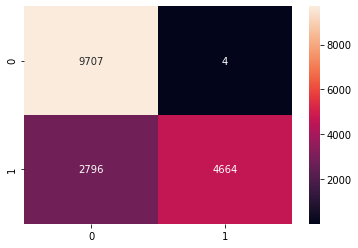

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_DoS_test, Y_DoS_pred).ravel()
conf_mat = confusion_matrix(Y_DoS_test, Y_DoS_pred)
seaborn.heatmap(conf_mat, annot=True, fmt="d")
plt.show()

In [ ]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99604 (+/- 0.00403)
Precision: 0.99639 (+/- 0.00394)
Recall: 0.99391 (+/- 0.00602)
F-measure: 0.99404 (+/- 0.00453)


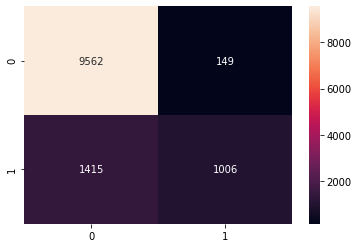

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_Probe_test, Y_Probe_pred).ravel()
conf_mat = confusion_matrix(Y_Probe_test, Y_Probe_pred)
seaborn.heatmap(conf_mat, annot=True, fmt="d")
plt.show()